# MCMC (Markov Chain Monte Carlo)

GPflow allows you to approximate the posterior over the latent functions of its models (and over the hyperparemeters after setting a prior for those) using Hamiltonian Monte Carlo (HMC)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

import gpflow
from gpflow.ci_utils import ci_niter
from gpflow import set_trainable
from multiclass_classification import plot_from_samples, colors

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-4)
gpflow.config.set_default_summary_fmt("notebook")
# convert to float64 for tfp to play nicely with gpflow in 64
f64 = gpflow.utilities.to_default_float

tf.random.set_seed(123)


%matplotlib inline


In this notebook, we provide three examples:

* [Example 1](#Example-1:-GP-regression): Sampling hyperparameters in Gaussian process regression
* [Example 2](#Example-2:-Sparse-MC-for-multiclass-classification): Sparse Variational MC applied to the multiclass classification problem
* [Example 3](#Example-3:-Fully-Bayesian-inference-for-generalized-GP-models-with-HMC): Full Bayesian inference for Gaussian process models

## Example 1: GP regression

We first consider the GP regression (with Gaussian noise) for which the marginal likelihood $p(\mathbf y\,|\,\theta)$ can be computed exactly.

The GPR model parameterized by $\theta = [\tau]$ is given by
\begin{equation}
Y_i = f(X_i) + \varepsilon_i
\end{equation}
where $f \sim \mathcal{GP}(\mu(.), k(., .))$, and $\varepsilon \sim \mathcal{N}(0, \tau^2 I)$.

See the [Basic (Gaussian likelihood) GP regression model](../basics/regression.ipynb) for more details on GPR and for a treatment of the direct likelihood maximization.



### Data for a one-dimensional regression problem

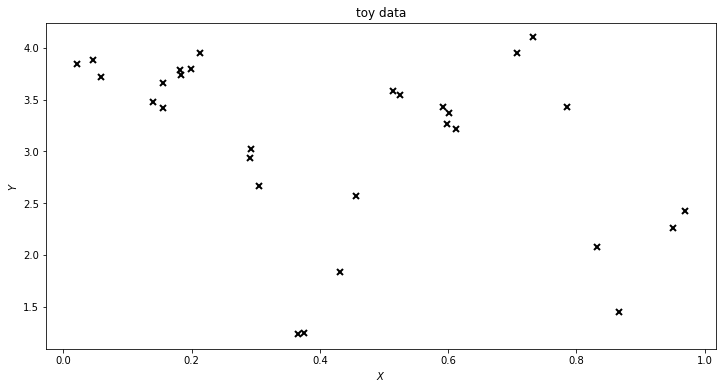

In [2]:
rng = np.random.RandomState(42)

N = 30


def synthetic_data(num: int, rng: np.random.RandomState):
    X = rng.rand(num, 1)
    Y = np.sin(12 * X) + 0.66 * np.cos(25 * X) + rng.randn(num, 1) * 0.1 + 3
    return X, Y


data = (X, Y) = synthetic_data(N, rng)

plt.figure(figsize=(12, 6))
plt.plot(X, Y, "kx", mew=2)
plt.xlabel("$X$")
plt.ylabel("$Y$")
plt.title("toy data")
plt.show()

### MCMC for hyperparameters $\theta$

We now want to sample from the posterior over $\theta$:
\begin{equation}
p(\theta|\mathbf{y}) \propto p(\mathbf{y}|\theta)p(\theta)
\end{equation}

Firstly, we build the GPR model.

In [3]:
kernel = gpflow.kernels.Matern52(lengthscales=0.3)
mean_function = gpflow.mean_functions.Linear(1.0, 0.0)
model = gpflow.models.GPR(data, kernel, mean_function, noise_variance=0.01)

Secondly, we initialize the model to the maximum likelihood solution.

In [4]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables)

print(f"log posterior density at optimum: {model.log_posterior_density()}")

log posterior density at optimum: -2.4371366970700805


Thirdly, we add priors to the hyperparameters.

In [5]:
# tfp.distributions dtype is inferred from parameters - so convert to 64-bit
model.kernel.lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.likelihood.variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.mean_function.A.prior = tfd.Normal(f64(0.0), f64(10.0))
model.mean_function.b.prior = tfd.Normal(f64(0.0), f64(10.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPR.mean_function.A,Parameter,Identity,Normal,True,"(1, 1)",float64,[[-1.06377032]]
GPR.mean_function.b,Parameter,Identity,Normal,True,(),float64,3.5474603444018453
GPR.kernel.variance,Parameter,Softplus,Gamma,True,(),float64,0.9357531803028016
GPR.kernel.lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.1039023714210897
GPR.likelihood.variance,Parameter,Softplus + Shift,Gamma,True,(),float64,0.005756764054347273


We now sample from the posterior using HMC.

In [6]:
num_burnin_steps = ci_niter(300)
num_samples = ci_niter(500)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}

**NOTE:** All the Hamiltonian MCMC sampling takes place in an unconstrained space (where constrained parameters have been mapped via a bijector to an unconstrained space). This makes the optimization, as required in the gradient step, much easier.

However, we often wish to sample the constrained parameter values, not the unconstrained one. The `SamplingHelper` helps us convert our unconstrained values to constrained parameter ones.


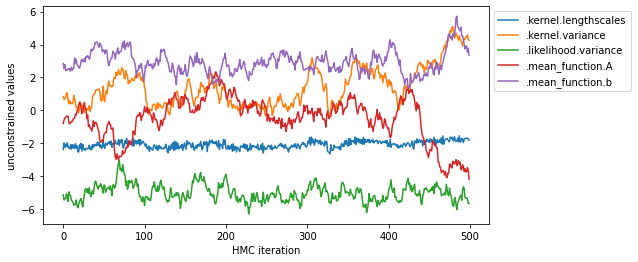

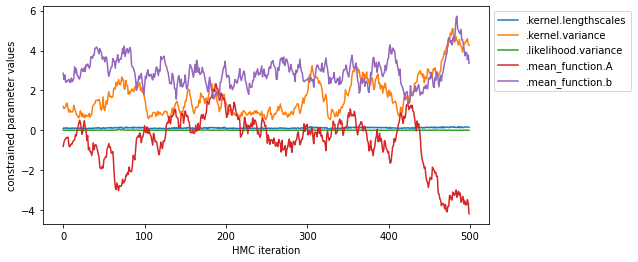

In [7]:
def plot_samples(samples, parameters, y_axis_label):
    plt.figure(figsize=(8, 4))
    for val, param in zip(samples, parameters):
        plt.plot(tf.squeeze(val), label=param_to_name[param])
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.xlabel("HMC iteration")
    plt.ylabel(y_axis_label)


plot_samples(samples, model.trainable_parameters, "unconstrained values")
plot_samples(parameter_samples, model.trainable_parameters, "constrained parameter values")

You can also inspect the marginal distribution of samples.

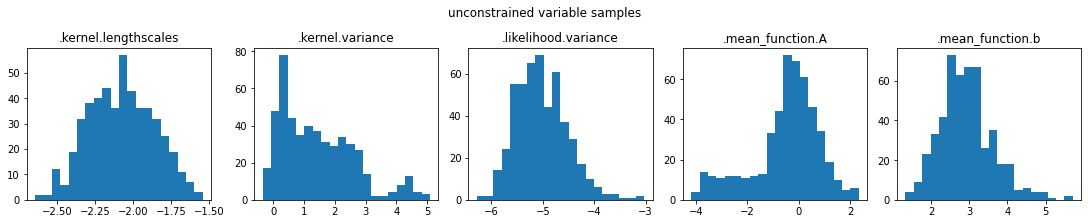

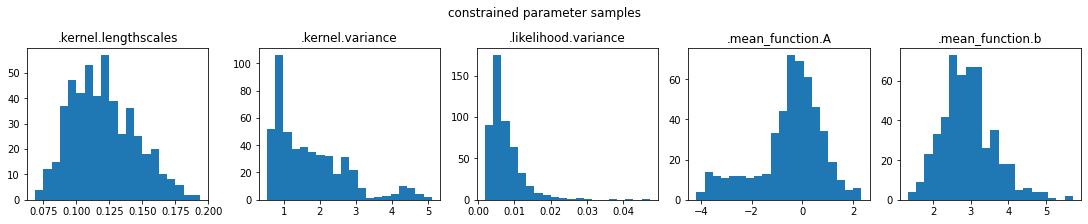

In [8]:
def marginal_samples(samples, parameters, y_axis_label):
    fig, axes = plt.subplots(1, len(param_to_name), figsize=(15, 3), constrained_layout=True)
    for ax, val, param in zip(axes, samples, parameters):
        ax.hist(np.stack(val).flatten(), bins=20)
        ax.set_title(param_to_name[param])
    fig.suptitle(y_axis_label)
    plt.show()


marginal_samples(samples, model.trainable_parameters, "unconstrained variable samples")
marginal_samples(parameter_samples, model.trainable_parameters, "constrained parameter samples")



**NOTE:** The sampler runs in unconstrained space (so that positive parameters remain positive, and parameters that are not trainable are ignored).

For serious analysis you most certainly want to run the sampler longer, with multiple chains and convergence checks. This will do for illustration though!


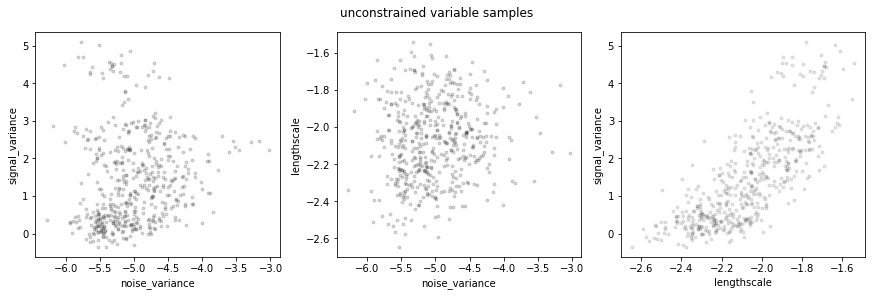

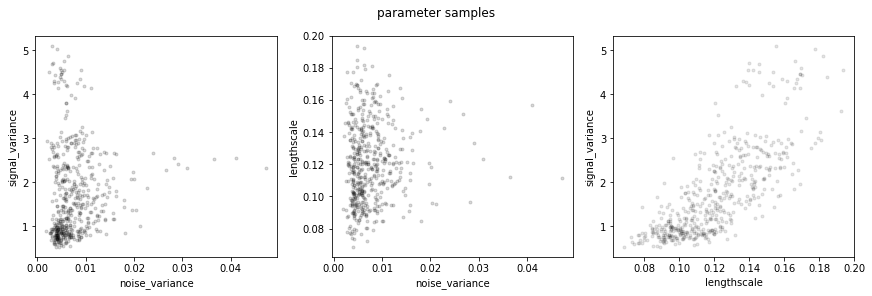

In [9]:
def plot_joint_marginals(samples, parameters, y_axis_label):
    name_to_index = {param_to_name[param]: i for i, param in enumerate(parameters)}
    f, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

    axs[0].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.15,
    )
    axs[0].set_xlabel("noise_variance")
    axs[0].set_ylabel("signal_variance")

    axs[1].plot(
        samples[name_to_index[".likelihood.variance"]],
        samples[name_to_index[".kernel.lengthscales"]],
        "k.",
        alpha=0.15,
    )
    axs[1].set_xlabel("noise_variance")
    axs[1].set_ylabel("lengthscale")

    axs[2].plot(
        samples[name_to_index[".kernel.lengthscales"]],
        samples[name_to_index[".kernel.variance"]],
        "k.",
        alpha=0.1,
    )
    axs[2].set_xlabel("lengthscale")
    axs[2].set_ylabel("signal_variance")
    f.suptitle(y_axis_label)
    plt.show()


plot_joint_marginals(samples, model.trainable_parameters, "unconstrained variable samples")
plot_joint_marginals(parameter_samples, model.trainable_parameters, "parameter samples")

To plot the posterior of predictions, we'll iterate through the samples and set the model state with each sample. Then, for that state (set of hyperparameters) we'll draw some samples from the prediction function.

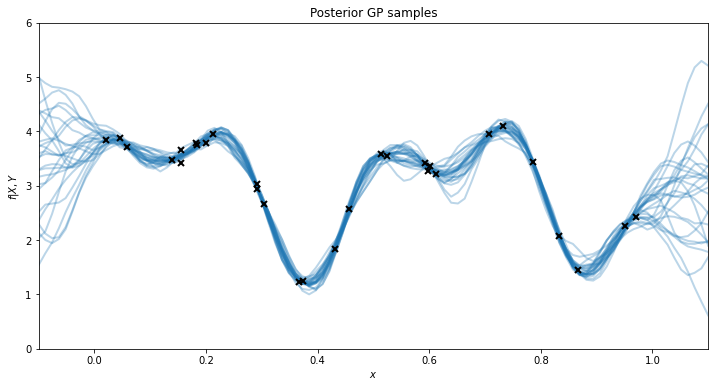

In [10]:
# plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:, None]
plt.figure(figsize=(12, 6))

for i in range(0, num_samples, 20):
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(xx, 1)
    plt.plot(xx, f[0, :, :], "C0", lw=2, alpha=0.3)

plt.plot(X, Y, "kx", mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)
plt.xlabel("$x$")
plt.ylabel("$f|X,Y$")
plt.title("Posterior GP samples")

plt.show()

## Example 2: Sparse MC for multiclass classification

We now consider the multiclass classification problem (see the [Multiclass classification](../advanced/multiclass_classification.ipynb) notebook). Here the marginal likelihood is not available in closed form. Instead we use a sparse variational approximation where we approximate the posterior for each GP as $q(f_c) \propto p(f_c|\mathbf{u}_c)q(\mathbf{u}_c)$

In the standard Sparse Variational GP (SVGP) formulation, $q(\mathbf{u_c})$ is parameterized as a multivariate Gaussian.

An alternative is to directly sample from the optimal $q(\mathbf{u}_c)$; this is what Sparse Variational GP using MCMC (SGPMC) does.

We first build a multiclass classification dataset.

In [11]:
# Generate data by sampling from SquaredExponential kernel, and classifying with the argmax
rng = np.random.RandomState(42)

C, N = 3, 100
X = rng.rand(N, 1)
kernel = gpflow.kernels.SquaredExponential(lengthscales=0.1)
K = kernel.K(X) + np.eye(N) * 1e-6

f = rng.multivariate_normal(mean=np.zeros(N), cov=K, size=(C)).T
Y = np.argmax(f, 1).reshape(-1,).astype(int)
# One-hot encoding
Y_hot = np.zeros((N, C), dtype=bool)
Y_hot[np.arange(N), Y] = 1

data = (X, Y)

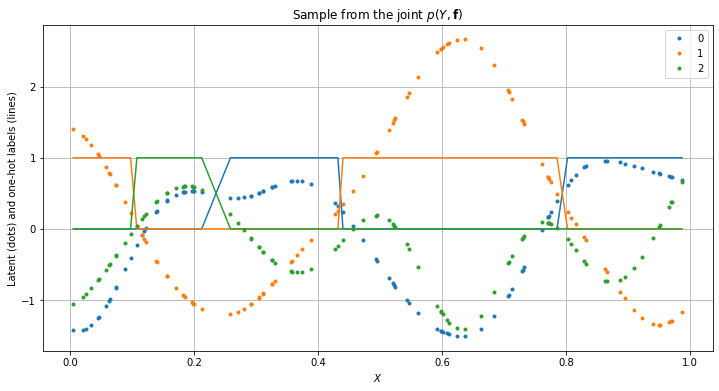

In [12]:
plt.figure(figsize=(12, 6))
order = np.argsort(X.reshape(-1,))

for c in range(C):
    plt.plot(X[order], f[order, c], ".", color=colors[c], label=str(c))
    plt.plot(X[order], Y_hot[order, c], "-", color=colors[c])

plt.legend()
plt.xlabel("$X$")
plt.ylabel("Latent (dots) and one-hot labels (lines)")
plt.title("Sample from the joint $p(Y, \mathbf{f})$")
plt.grid()
plt.show()

We then build the SGPMC model.

In [13]:
kernel = gpflow.kernels.Matern32(lengthscales=0.1) + gpflow.kernels.White(variance=0.01)

model = gpflow.models.SGPMC(
    data,
    kernel=kernel,
    likelihood=gpflow.likelihoods.MultiClass(3),
    inducing_variable=X[::5].copy(),
    num_latent_gps=3,
)
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(2.0), f64(2.0))
set_trainable(model.kernel.kernels[1].variance, False)

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
SGPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
SGPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,(),float64,0.10000000000000002
SGPMC.kernel.kernels[1].variance,Parameter,Softplus,,False,(),float64,0.009999999999999998
SGPMC.likelihood.invlink.epsilon,Parameter,Sigmoid,Beta,False,(),float64,0.0010000000000000005
SGPMC.inducing_variable.Z,Parameter,Identity,,True,"(20, 1)",float64,[[0.37454012...
SGPMC.V,Parameter,Identity,Normal,True,"(20, 3)",float64,"[[0., 0., 0...."


In [14]:
# The inducing point locations Z should not be included in the MCMC (see [Hensman et al. (2015)](https://papers.nips.cc/paper/5875-mcmc-for-variationally-sparse-gaussian-processes), hence we set them to non-trainable.
set_trainable(model.inducing_variable, False)

The chain of samples for $\mathbf{u}_c, \theta$ is initialized at the value maximizing  $p(Y|\mathbf{u}_c, \theta)$.

In [15]:
optimizer = gpflow.optimizers.Scipy()
optimizer.minimize(model.training_loss, model.trainable_variables, options={"maxiter": 20})
print(f"log posterior density at optimum: {model.log_posterior_density()}")

log posterior density at optimum: -79.76549027481077


Sampling starts with a 'burn in' period.

In [16]:
num_burnin_steps = ci_niter(100)
num_samples = ci_niter(500)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, _ = run_chain_fn()
constrained_samples = hmc_helper.convert_to_constrained_values(samples)

Statistics of the posterior samples can now be reported.

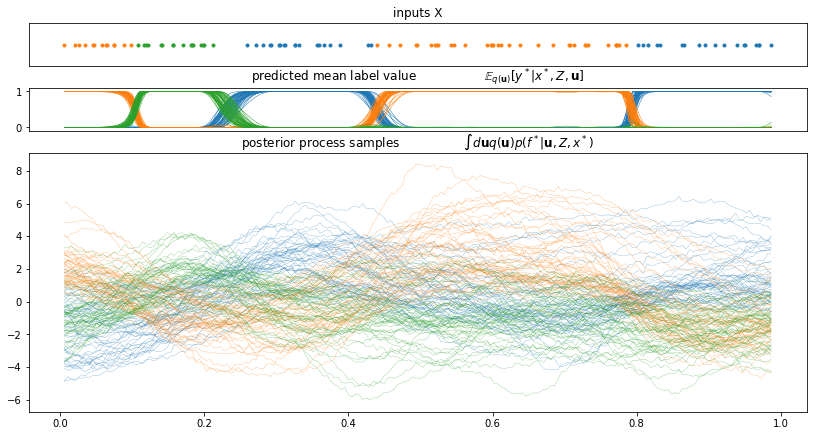

In [17]:
plot_from_samples(model, X, Y, model.trainable_parameters, constrained_samples, thin=10)

You can also display the sequence of sampled hyperparameters.

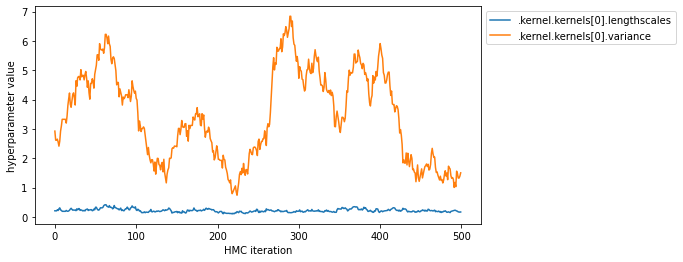

In [18]:
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in enumerate(model.trainable_parameters)}
hyperparameters = [".kernel.kernels[0].lengthscales", ".kernel.kernels[0].variance"]

plt.figure(figsize=(8, 4))
for param_name in hyperparameters:
    plt.plot(constrained_samples[name_to_index[param_name]], label=param_name)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("HMC iteration")
_ = plt.ylabel("hyperparameter value")

## Example 3: Fully Bayesian inference for generalized GP models with HMC

You can construct very flexible models with Gaussian processes by combining them with different likelihoods (sometimes called 'families' in the GLM literature). This makes inference of the GP intractable because the likelihoods are not generally conjugate to the Gaussian process. The general form of the model is
\begin{align}
\theta &\sim p(\theta) \\
f &\sim \mathcal {GP}(m(x; \theta),\, k(x, x'; \theta)) \\
y_i &\sim p(y | g(f(x_i))\,.
\end{align}


To perform inference in this model, we'll run MCMC using Hamiltonian Monte Carlo (HMC) over the function values and the parameters $\theta$ jointly. The key to an effective scheme is rotation of the field using the Cholesky decomposition. We write:

\begin{align}
\theta &\sim p(\theta) \\
v &\sim \mathcal {N}(0,\, I) \\
LL^\top &= K \\
f &= m + Lv \\
y_i &\sim p(y | g(f(x_i))\,.
\end{align}

Joint HMC over $v$ and the function values is not widely adopted in the literature because of the difficulty in differentiating $LL^\top=K$. We've made this derivative available in TensorFlow, and so application of HMC is relatively straightforward.

### Exponential Regression
We consider an exponential regression model:
\begin{align}
\theta &\sim p(\theta) \\
f &\sim \mathcal {GP}(0, k(x, x'; \theta)) \\
f_i &= f(x_i) \\
y_i &\sim \mathcal {Exp} (e^{f_i})
\end{align}

We'll use MCMC to deal with both the kernel parameters $\theta$ and the latent function values $f$. Firstly, generate a data set.

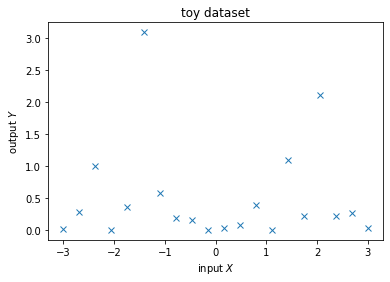

In [19]:
rng = np.random.RandomState(14)

X = np.linspace(-3, 3, 20)
Y = rng.exponential(np.sin(X) ** 2)

plt.figure()
plt.plot(X, Y, "x")
plt.xlabel("input $X$")
plt.ylabel("output $Y$")
plt.title("toy dataset")
plt.show()

data = (X[:, None], Y[:, None])

GPflow's model for fully-Bayesian MCMC is called GPMC. It's constructed like any other model, but contains a parameter `V` which represents the centered values of the function.

In [20]:
kernel = gpflow.kernels.Matern32() + gpflow.kernels.Constant()
likelihood = gpflow.likelihoods.Exponential()
model = gpflow.models.GPMC(data, kernel, likelihood)

The `V` parameter already has a prior applied. We'll add priors to the parameters also (these are rather arbitrary, for illustration).

In [21]:
model.kernel.kernels[0].lengthscales.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[0].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))
model.kernel.kernels[1].variance.prior = tfd.Gamma(f64(1.0), f64(1.0))

gpflow.utilities.print_summary(model)

name,class,transform,prior,trainable,shape,dtype,value
GPMC.kernel.kernels[0].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[0].lengthscales,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.kernel.kernels[1].variance,Parameter,Softplus,Gamma,True,(),float64,1.0
GPMC.V,Parameter,Identity,Normal,True,"(20, 1)",float64,[[0....


Running HMC is pretty similar to optimizing a model. GPflow builds on top of [tensorflow_probability's mcmc module](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc) and provides a SamplingHelper class to make interfacing easier.

We initialize HMC at the maximum a posteriori parameter values of the model.

In [22]:
optimizer = gpflow.optimizers.Scipy()
maxiter = ci_niter(3000)
_ = optimizer.minimize(
    model.training_loss, model.trainable_variables, options=dict(maxiter=maxiter)
)
# We can now start HMC near maximum a posteriori (MAP)

We then run the sampler,

In [23]:
num_burnin_steps = ci_niter(600)
num_samples = ci_niter(1000)

# Note that here we need model.trainable_parameters, not trainable_variables - only parameters can have priors!
hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)

adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, _ = run_chain_fn()

And compute the posterior prediction on a grid for plotting purposes.

In [24]:
Xtest = np.linspace(-4, 4, 100)[:, None]
f_samples = []

for i in range(num_samples):
    # Note that hmc_helper.current_state contains the unconstrained variables
    for var, var_samples in zip(hmc_helper.current_state, samples):
        var.assign(var_samples[i])
    f = model.predict_f_samples(Xtest, 5)
    f_samples.append(f)
f_samples = np.vstack(f_samples)

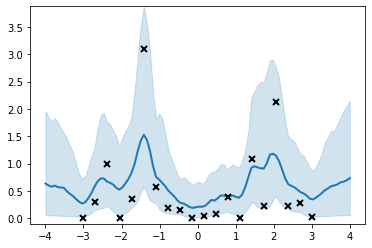

In [25]:
rate_samples = np.exp(f_samples[:, :, 0])

(line,) = plt.plot(Xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(
    Xtest[:, 0],
    np.percentile(rate_samples, 5, axis=0),
    np.percentile(rate_samples, 95, axis=0),
    color=line.get_color(),
    alpha=0.2,
)

plt.plot(X, Y, "kx", mew=2)
_ = plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))

You can also display the sequence of sampled hyperparameters.

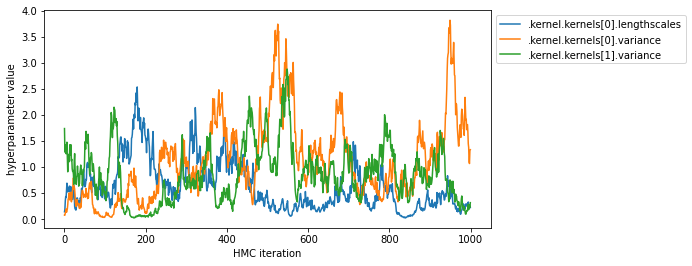

In [26]:
parameter_samples = hmc_helper.convert_to_constrained_values(samples)
param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
name_to_index = {param_to_name[param]: i for i, param in enumerate(model.trainable_parameters)}
hyperparameters = [
    ".kernel.kernels[0].lengthscales",
    ".kernel.kernels[0].variance",
    ".kernel.kernels[1].variance",
]


plt.figure(figsize=(8, 4))
for param_name in hyperparameters:
    plt.plot(parameter_samples[name_to_index[param_name]], label=param_name)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.xlabel("HMC iteration")
_ = plt.ylabel("hyperparameter value")

You can also inspect the marginal of the posterior samples.

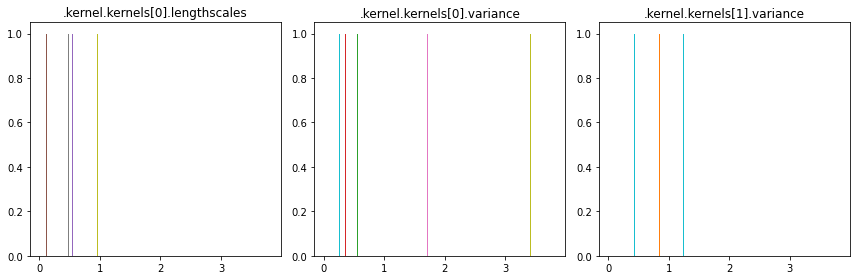

In [27]:
fig, axes = plt.subplots(1, len(hyperparameters), sharex=True, figsize=(12, 4))
for ax, param_name in zip(axes, hyperparameters):
    ax.hist(parameter_samples[name_to_index[param_name]], bins=20)
    ax.set_title(param_name)
plt.tight_layout()

## Prior on constrained and unconstrained parameters

GPflow's `Parameter` class provides options for setting a prior. `Parameter` wraps a constrained tensor and
provides computation of the gradient with respect to unconstrained transformation of that tensor.
The user can set a prior either in **constrained** space or **unconstrained** space.

By default, the prior for the `Parameter` is set on the _constrained_ space.
To explicitly set the space on which the prior is defined, use the `prior_on` keyword argument:

In [28]:
prior_distribution = tfd.Normal(f64(0.0), f64(1.0))
_ = gpflow.Parameter(1.0, prior_on="unconstrained", prior=prior_distribution)
_ = gpflow.Parameter(1.0, prior_on="constrained", prior=prior_distribution)

`gpflow.optimizers.SamplingHelper` makes sure that the prior density correctly reflects the space in which the prior is defined.

Below we repeat the same experiment as before, but with some priors defined in the `unconstrained` space.
We are using the exponential transform to ensure positivity of the kernel parameters (`set_default_positive_bijector("exp")`),
so a log-normal prior on a constrained parameter corresponds to a normal prior on the unconstrained space:

In [29]:
gpflow.config.set_default_positive_bijector("exp")
gpflow.config.set_default_positive_minimum(1e-6)

rng = np.random.RandomState(42)
data = synthetic_data(30, rng)

kernel = gpflow.kernels.Matern52(lengthscales=0.3)
meanf = gpflow.mean_functions.Linear(1.0, 0.0)
model = gpflow.models.GPR(data, kernel, meanf)
model.likelihood.variance.assign(0.01)

mu = f64(0.0)
std = f64(4.0)
one = f64(1.0)

model.kernel.lengthscales.prior_on = "unconstrained"
model.kernel.lengthscales.prior = tfd.Normal(mu, std)
model.kernel.variance.prior_on = "unconstrained"
model.kernel.variance.prior = tfd.Normal(mu, std)
model.likelihood.variance.prior_on = "unconstrained"
model.likelihood.variance.prior = tfd.Normal(mu, std)

model.mean_function.A.prior_on = "constrained"
model.mean_function.A.prior = tfd.Normal(mu, std)
model.mean_function.b.prior_on = "constrained"
model.mean_function.b.prior = tfd.Normal(mu, std)

model.kernel.lengthscales.prior_on

<PriorOn.UNCONSTRAINED: 'unconstrained'>

Let's run HMC and plot chain traces:

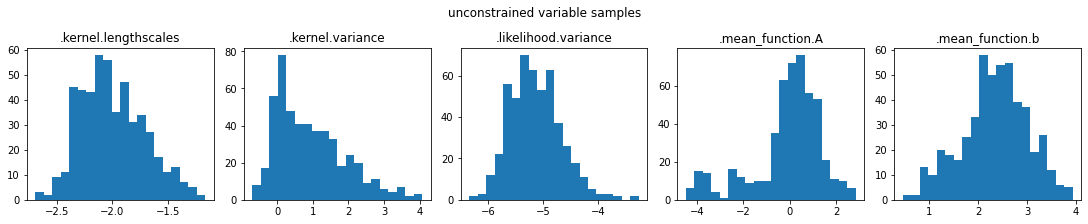

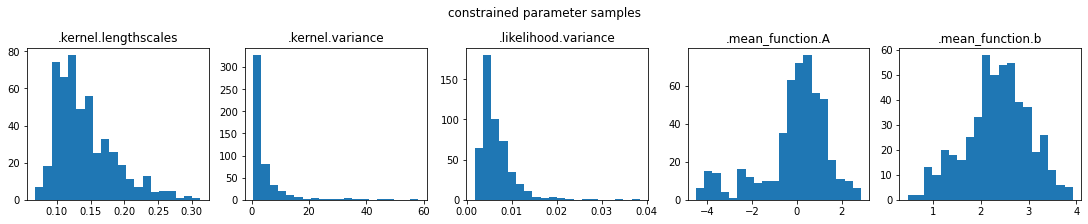

In [30]:
num_burnin_steps = ci_niter(300)
num_samples = ci_niter(500)

hmc_helper = gpflow.optimizers.SamplingHelper(
    model.log_posterior_density, model.trainable_parameters
)

hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=hmc_helper.target_log_prob_fn, num_leapfrog_steps=10, step_size=0.01
)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    hmc, num_adaptation_steps=10, target_accept_prob=f64(0.75), adaptation_rate=0.1
)


@tf.function
def run_chain_fn_unconstrained():
    return tfp.mcmc.sample_chain(
        num_results=num_samples,
        num_burnin_steps=num_burnin_steps,
        current_state=hmc_helper.current_state,
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr.inner_results.is_accepted,
    )


samples, traces = run_chain_fn_unconstrained()
parameter_samples = hmc_helper.convert_to_constrained_values(samples)

param_to_name = {param: name for name, param in gpflow.utilities.parameter_dict(model).items()}
marginal_samples(samples, model.trainable_parameters, "unconstrained variable samples")
marginal_samples(parameter_samples, model.trainable_parameters, "constrained parameter samples")